In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd drive/'My Drive'/BA_impl/Improving_Siamese_Networks_for_One_shot_learning

/content/drive/My Drive/BA_impl/Improving_Siamese_Networks_for_One_shot_learning


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import PIL.ImageOps
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib

from activation import KAF, KAF2D
from loss import ContrastiveLoss

cuda = torch.cuda.is_available()
%matplotlib inline

print(cuda)

True


In [4]:
def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
                bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

In [5]:
class Config():
    training_dir = 'faces/training/'
    testing_dir = 'faces/testing/'
    train_batch_size = 64
    train_number_epochs = 50

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None, invert=True):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        get_same_class = random.randint(0,1)
        if get_same_class:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break
                    
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
            
        if self.transform != None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
folder_dataset = dsets.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                        invert=False)

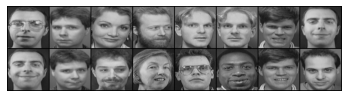

[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [9]:
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            num_workers=2,
                            batch_size=8)
dataiter = iter(vis_dataloader)

exmp_batch = next(dataiter)
concat = torch.cat((exmp_batch[0], exmp_batch[1]), 0)
imshow(torchvision.utils.make_grid(concat))
print(exmp_batch[2].numpy())

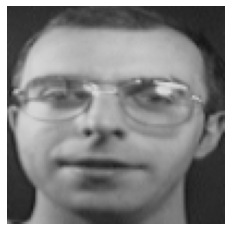

torch.Size([1, 100, 100])


In [10]:
imshow(torchvision.utils.make_grid(exmp_batch[0][0]))
print(exmp_batch[0][0].shape)

In [12]:
class SiameseNetwork_ReLU(nn.Module):
    def __init__(self):
        super(SiameseNetwork_ReLU, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(10*10*8, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 250),
            nn.ReLU(inplace=True),
            nn.Linear(250, 5),
            nn.ReLU(inplace=True)
        )
        
    def forward_once(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
class SiameseNetwork_KAF(nn.Module):
    def __init__(self):
        super(SiameseNetwork_KAF, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3),
            KAF(4),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3),
            KAF(8),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3),
            KAF(8),
            nn.MaxPool2d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(10*10*8, 500),
            KAF(500),
            nn.Linear(500, 250),
            KAF(250),
            nn.Linear(250, 5),
            KAF(5)
        )
        
    def forward_once(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [13]:
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=Config.train_batch_size)

In [18]:
net = SiameseNetwork_ReLU().cuda()
criterion = ContrastiveLoss(1.0)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [19]:
counter = []
loss_history = []
iteration_number = 0

Epoch number 0
 Current loss 17.95122528076172 

Epoch number 1
 Current loss 16.248218536376953 

Epoch number 2
 Current loss 14.11889934539795 

Epoch number 3
 Current loss 12.80877685546875 

Epoch number 4
 Current loss 12.560653686523438 

Epoch number 5
 Current loss 11.710366249084473 

Epoch number 6
 Current loss 12.52294921875 

Epoch number 7
 Current loss 10.037213325500488 

Epoch number 8
 Current loss 10.236801147460938 

Epoch number 9
 Current loss 10.622855186462402 

Epoch number 10
 Current loss 11.828351974487305 

Epoch number 11
 Current loss 10.02790355682373 

Epoch number 12
 Current loss 9.765953063964844 

Epoch number 13
 Current loss 10.536856651306152 

Epoch number 14
 Current loss 9.135910987854004 

Epoch number 15
 Current loss 10.142325401306152 

Epoch number 16
 Current loss 10.083623886108398 

Epoch number 17
 Current loss 8.979469299316406 

Epoch number 18
 Current loss 10.545482635498047 

Epoch number 19
 Current loss 9.108640670776367 

Ep

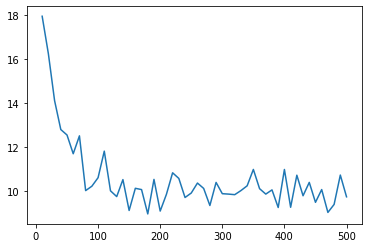

In [20]:
for epoch in range(Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("Epoch number {}\n Current loss {} \n".format(epoch, loss.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.item())
show_plot(counter, loss_history)            

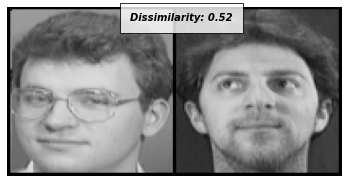

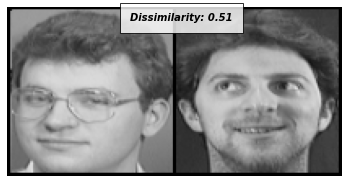

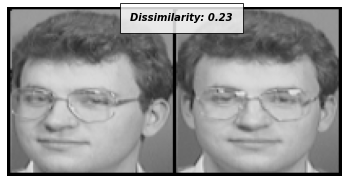

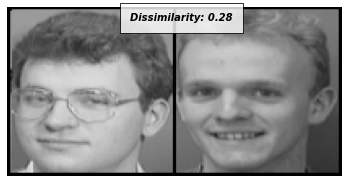

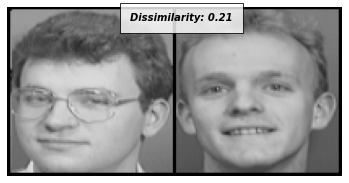

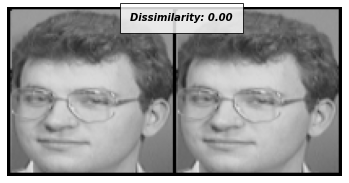

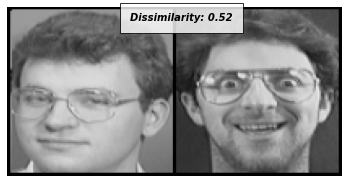

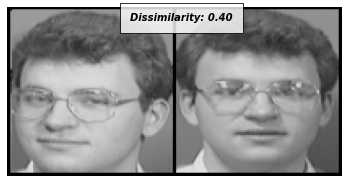

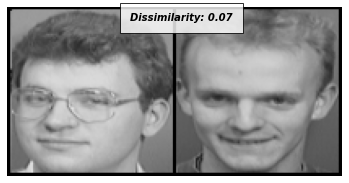

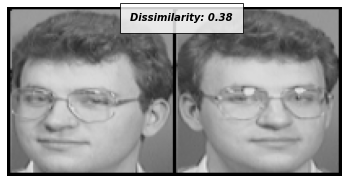

In [21]:
folder_dataset_test = dsets.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [22]:
net = SiameseNetwork_KAF().cuda()
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

/content/drive/My Drive/BA_impl/Improving_Siamese_Networks_for_One_shot_learning/activation.py:53: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  normal(self.alpha.data, std=0.3)


In [23]:
counter = []
loss_history = []
iteration_number = 0

Epoch number 0
 Current loss 14.375051498413086 

Epoch number 1
 Current loss 16.08332061767578 

Epoch number 2
 Current loss 9.735410690307617 

Epoch number 3
 Current loss 9.79284381866455 

Epoch number 4
 Current loss 11.530097961425781 

Epoch number 5
 Current loss 10.542366981506348 

Epoch number 6
 Current loss 11.630056381225586 

Epoch number 7
 Current loss 10.539543151855469 

Epoch number 8
 Current loss 9.29708480834961 

Epoch number 9
 Current loss 9.545326232910156 

Epoch number 10
 Current loss 10.345732688903809 

Epoch number 11
 Current loss 11.542198181152344 

Epoch number 12
 Current loss 10.309988975524902 

Epoch number 13
 Current loss 10.360581398010254 

Epoch number 14
 Current loss 9.27649211883545 

Epoch number 15
 Current loss 10.467034339904785 

Epoch number 16
 Current loss 10.503478050231934 

Epoch number 17
 Current loss 9.72919750213623 

Epoch number 18
 Current loss 9.71124267578125 

Epoch number 19
 Current loss 9.431289672851562 

Epoc

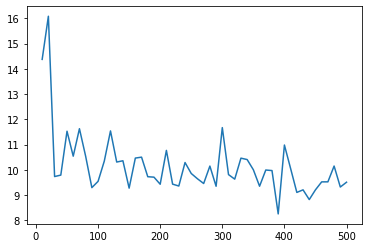

In [24]:
for epoch in range(Config.train_number_epochs):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("Epoch number {}\n Current loss {} \n".format(epoch, loss.item()))
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss.item())
show_plot(counter, loss_history)            

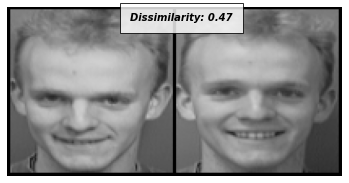

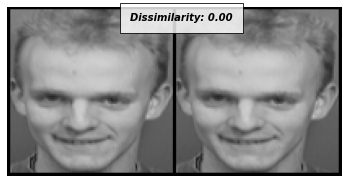

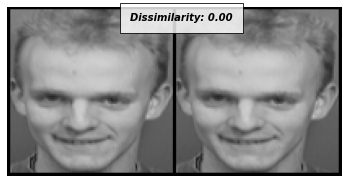

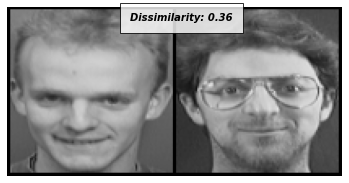

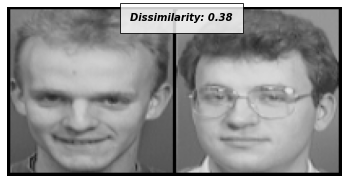

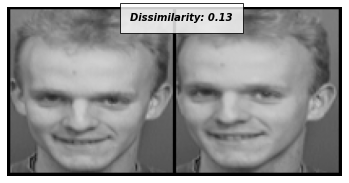

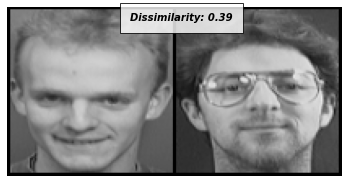

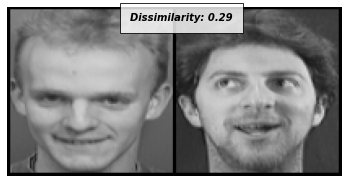

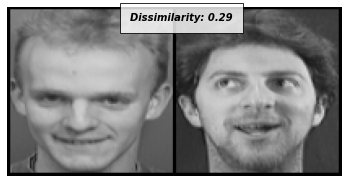

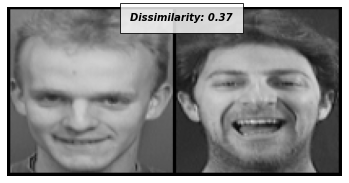

In [98]:
folder_dataset_test = dsets.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))